In [1]:
from model import ModelWithActivations
from torchvision.models import vgg16
import pathlib
from tqdm import tqdm
import torch
import torch.nn as nn
import numbers
import math
import scipy.ndimage as nd
import numpy as np
# from pyramid_image import load_image

In [75]:
import torch.nn.functional as F
from torchmetrics.functional import total_variation

def train_dream(dream_model, input_image, iterations=10):
    input_image.requires_grad = True
    for iteration in tqdm(range(iterations)):
        out = dream_model(input_image)
        activations = dream_model.get_target_activation(71)#get_all_activations()
        losses = [torch.linalg.vector_norm(activation, ord=2) for activation in activations] # TRZEBA OGARNAC DOBRY LOSS, zeby sie uczylo. Srednia nie dziala
        loss = torch.mean(torch.stack(losses))
        loss = loss - 0.1 * total_variation(input_image) #71
        print(loss)
        loss.backward()
        grad = input_image.grad.data
        grad = 1.5 / torch.mean(torch.abs(grad)) * grad
#         grad = CascadeGaussianSmoothing(kernel_size=9, sigma=3)(grad)
#         grad_std = torch.std(grad)
#         grad_mean = torch.mean(grad)
#         grad -= grad_mean
#         grad /= grad_std
        input_image.data += 0.1 * grad
        input_image.grad.data.zero_()
    return input_image
            
        

In [76]:
from deepdream import optimize_image
from image import load_image

In [80]:
image_path = pathlib.Path("examples/amazon.jpg")
image = np.random.rand(3, 500, 500).astype(dtype=np.float32)
dream_model = ModelWithActivations(vgg16(pretrained=True))


octaves = [image]
octave_n = 3
octave_scale = 1.4
n_iter = 30
for i in range(octave_n-1):
    octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))

detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
for octave, octave_base in enumerate(octaves[::-1]):
    h, w = octave_base.shape[-2:]
    if octave > 0:
        # upscale details from the previous octave
        h1, w1 = detail.shape[-2:]
        detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

    input_image = octave_base+detail
    input_image_torch = torch.unsqueeze(torch.from_numpy(input_image), 0)
    input_image_torch = train_dream(dream_model, input_image_torch, n_iter)
    input_image = np.squeeze(input_image_torch.detach().numpy())
    detail = input_image-octave_base
# returning the resulting image

  0%|                                                                         | 0/30 [00:00<?, ?it/s]

tensor(-5520.2588, grad_fn=<SubBackward0>)


  3%|██▏                                                              | 1/30 [00:00<00:26,  1.08it/s]

tensor(-5377.5728, grad_fn=<SubBackward0>)


  7%|████▎                                                            | 2/30 [00:02<00:28,  1.02s/it]

tensor(-5439.1890, grad_fn=<SubBackward0>)


 10%|██████▌                                                          | 3/30 [00:02<00:27,  1.00s/it]

tensor(-5423.9575, grad_fn=<SubBackward0>)


 13%|████████▋                                                        | 4/30 [00:04<00:26,  1.01s/it]

tensor(-5501.1182, grad_fn=<SubBackward0>)


 17%|██████████▊                                                      | 5/30 [00:05<00:25,  1.03s/it]

tensor(-5480.5117, grad_fn=<SubBackward0>)


 20%|█████████████                                                    | 6/30 [00:06<00:24,  1.04s/it]

tensor(-5531.8027, grad_fn=<SubBackward0>)


 23%|███████████████▏                                                 | 7/30 [00:07<00:23,  1.02s/it]

tensor(-5513.0977, grad_fn=<SubBackward0>)


 27%|█████████████████▎                                               | 8/30 [00:08<00:22,  1.02s/it]

tensor(-5563.5190, grad_fn=<SubBackward0>)


 30%|███████████████████▌                                             | 9/30 [00:09<00:21,  1.01s/it]

tensor(-5554.9263, grad_fn=<SubBackward0>)


 33%|█████████████████████▎                                          | 10/30 [00:10<00:19,  1.00it/s]

tensor(-5554.1890, grad_fn=<SubBackward0>)


 37%|███████████████████████▍                                        | 11/30 [00:11<00:18,  1.01it/s]

tensor(-5570.9907, grad_fn=<SubBackward0>)


 40%|█████████████████████████▌                                      | 12/30 [00:12<00:17,  1.01it/s]

tensor(-5584.2251, grad_fn=<SubBackward0>)


 43%|███████████████████████████▋                                    | 13/30 [00:13<00:16,  1.01it/s]

tensor(-5568.3110, grad_fn=<SubBackward0>)


 47%|█████████████████████████████▊                                  | 14/30 [00:14<00:16,  1.02s/it]

tensor(-5650.2261, grad_fn=<SubBackward0>)


 50%|████████████████████████████████                                | 15/30 [00:15<00:15,  1.00s/it]

tensor(-5519.6870, grad_fn=<SubBackward0>)


 53%|██████████████████████████████████▏                             | 16/30 [00:16<00:13,  1.01it/s]

tensor(-5649.2354, grad_fn=<SubBackward0>)


 57%|████████████████████████████████████▎                           | 17/30 [00:17<00:12,  1.01it/s]

tensor(-5537.4297, grad_fn=<SubBackward0>)


 60%|██████████████████████████████████████▍                         | 18/30 [00:18<00:11,  1.02it/s]

tensor(-5667.3613, grad_fn=<SubBackward0>)


 63%|████████████████████████████████████████▌                       | 19/30 [00:18<00:10,  1.03it/s]

tensor(-5546.0635, grad_fn=<SubBackward0>)


 67%|██████████████████████████████████████████▋                     | 20/30 [00:19<00:09,  1.03it/s]

tensor(-5660.5859, grad_fn=<SubBackward0>)


 70%|████████████████████████████████████████████▊                   | 21/30 [00:20<00:08,  1.01it/s]

tensor(-5542.4023, grad_fn=<SubBackward0>)


 73%|██████████████████████████████████████████████▉                 | 22/30 [00:21<00:07,  1.01it/s]

tensor(-5710.0356, grad_fn=<SubBackward0>)


 77%|█████████████████████████████████████████████████               | 23/30 [00:22<00:06,  1.01it/s]

tensor(-5522.5767, grad_fn=<SubBackward0>)


 80%|███████████████████████████████████████████████████▏            | 24/30 [00:23<00:05,  1.01it/s]

tensor(-5715.0239, grad_fn=<SubBackward0>)


 83%|█████████████████████████████████████████████████████▎          | 25/30 [00:24<00:04,  1.02it/s]

tensor(-5514.0649, grad_fn=<SubBackward0>)


 87%|███████████████████████████████████████████████████████▍        | 26/30 [00:26<00:04,  1.03s/it]

tensor(-5795.7427, grad_fn=<SubBackward0>)


 90%|█████████████████████████████████████████████████████████▌      | 27/30 [00:27<00:03,  1.08s/it]

tensor(-5444.7217, grad_fn=<SubBackward0>)


 93%|███████████████████████████████████████████████████████████▋    | 28/30 [00:28<00:02,  1.05s/it]

tensor(-5818.5063, grad_fn=<SubBackward0>)


 97%|█████████████████████████████████████████████████████████████▊  | 29/30 [00:29<00:01,  1.04s/it]

tensor(-5410.2646, grad_fn=<SubBackward0>)


  0%|                                                                         | 0/30 [00:00<?, ?it/s]

tensor(-14717.4092, grad_fn=<SubBackward0>)


  3%|██▏                                                              | 1/30 [00:01<00:57,  1.99s/it]

tensor(-8818.7715, grad_fn=<SubBackward0>)


  7%|████▎                                                            | 2/30 [00:04<00:56,  2.03s/it]

tensor(-12116.8242, grad_fn=<SubBackward0>)


 10%|██████▌                                                          | 3/30 [00:05<00:52,  1.94s/it]

tensor(-9357.4434, grad_fn=<SubBackward0>)


 13%|████████▋                                                        | 4/30 [00:07<00:50,  1.92s/it]

tensor(-11957.9277, grad_fn=<SubBackward0>)


 17%|██████████▊                                                      | 5/30 [00:09<00:46,  1.87s/it]

tensor(-9643.4688, grad_fn=<SubBackward0>)


 20%|█████████████                                                    | 6/30 [00:11<00:44,  1.87s/it]

tensor(-11902.8359, grad_fn=<SubBackward0>)


 23%|███████████████▏                                                 | 7/30 [00:13<00:42,  1.87s/it]

tensor(-9800.1514, grad_fn=<SubBackward0>)


 27%|█████████████████▎                                               | 8/30 [00:15<00:40,  1.86s/it]

tensor(-11864.6289, grad_fn=<SubBackward0>)


 30%|███████████████████▌                                             | 9/30 [00:16<00:38,  1.86s/it]

tensor(-9906.7656, grad_fn=<SubBackward0>)


 33%|█████████████████████▎                                          | 10/30 [00:18<00:37,  1.89s/it]

tensor(-11846.3984, grad_fn=<SubBackward0>)


 37%|███████████████████████▍                                        | 11/30 [00:20<00:35,  1.89s/it]

tensor(-9985.1709, grad_fn=<SubBackward0>)


 40%|█████████████████████████▌                                      | 12/30 [00:22<00:33,  1.87s/it]

tensor(-11816.3779, grad_fn=<SubBackward0>)


 43%|███████████████████████████▋                                    | 13/30 [00:24<00:31,  1.84s/it]

tensor(-10049.4814, grad_fn=<SubBackward0>)


 47%|█████████████████████████████▊                                  | 14/30 [00:26<00:29,  1.84s/it]

tensor(-11800.1992, grad_fn=<SubBackward0>)


 50%|████████████████████████████████                                | 15/30 [00:28<00:27,  1.85s/it]

tensor(-10089.5381, grad_fn=<SubBackward0>)


 53%|██████████████████████████████████▏                             | 16/30 [00:29<00:25,  1.84s/it]

tensor(-11794.2783, grad_fn=<SubBackward0>)


 57%|████████████████████████████████████▎                           | 17/30 [00:31<00:23,  1.84s/it]

tensor(-10124.6445, grad_fn=<SubBackward0>)


 60%|██████████████████████████████████████▍                         | 18/30 [00:33<00:22,  1.83s/it]

tensor(-11796.7891, grad_fn=<SubBackward0>)


 63%|████████████████████████████████████████▌                       | 19/30 [00:35<00:20,  1.82s/it]

tensor(-10164.0938, grad_fn=<SubBackward0>)


 67%|██████████████████████████████████████████▋                     | 20/30 [00:37<00:18,  1.84s/it]

tensor(-11786.7510, grad_fn=<SubBackward0>)


 70%|████████████████████████████████████████████▊                   | 21/30 [00:39<00:16,  1.84s/it]

tensor(-10191.7119, grad_fn=<SubBackward0>)


 73%|██████████████████████████████████████████████▉                 | 22/30 [00:40<00:14,  1.81s/it]

tensor(-11775.3662, grad_fn=<SubBackward0>)


 77%|█████████████████████████████████████████████████               | 23/30 [00:42<00:12,  1.83s/it]

tensor(-10226.7334, grad_fn=<SubBackward0>)


 80%|███████████████████████████████████████████████████▏            | 24/30 [00:44<00:10,  1.81s/it]

tensor(-11767.1670, grad_fn=<SubBackward0>)


 83%|█████████████████████████████████████████████████████▎          | 25/30 [00:46<00:09,  1.80s/it]

tensor(-10250.2432, grad_fn=<SubBackward0>)


 87%|███████████████████████████████████████████████████████▍        | 26/30 [00:48<00:07,  1.86s/it]

tensor(-11737.4932, grad_fn=<SubBackward0>)


 90%|█████████████████████████████████████████████████████████▌      | 27/30 [00:50<00:05,  1.87s/it]

tensor(-10282.6162, grad_fn=<SubBackward0>)


 93%|███████████████████████████████████████████████████████████▋    | 28/30 [00:52<00:03,  1.91s/it]

tensor(-11726.8154, grad_fn=<SubBackward0>)


 97%|█████████████████████████████████████████████████████████████▊  | 29/30 [00:54<00:01,  1.90s/it]

tensor(-10307.7627, grad_fn=<SubBackward0>)


  0%|                                                                         | 0/30 [00:00<?, ?it/s]

tensor(-44082.1055, grad_fn=<SubBackward0>)


  3%|██▏                                                              | 1/30 [00:03<01:51,  3.84s/it]

tensor(-20338.4219, grad_fn=<SubBackward0>)


  7%|████▎                                                            | 2/30 [00:07<01:42,  3.66s/it]

tensor(-21566.4180, grad_fn=<SubBackward0>)


 10%|██████▌                                                          | 3/30 [00:10<01:37,  3.62s/it]

tensor(-20334.1328, grad_fn=<SubBackward0>)


 13%|████████▋                                                        | 4/30 [00:14<01:32,  3.57s/it]

tensor(-21550.3008, grad_fn=<SubBackward0>)


 17%|██████████▊                                                      | 5/30 [00:17<01:27,  3.51s/it]

tensor(-20662.0586, grad_fn=<SubBackward0>)


 20%|█████████████                                                    | 6/30 [00:22<01:32,  3.85s/it]

tensor(-21674.9414, grad_fn=<SubBackward0>)


 23%|███████████████▏                                                 | 7/30 [00:26<01:31,  3.98s/it]

tensor(-20860.5039, grad_fn=<SubBackward0>)


 27%|█████████████████▎                                               | 8/30 [00:31<01:36,  4.37s/it]

tensor(-21747.1953, grad_fn=<SubBackward0>)


 30%|███████████████████▌                                             | 9/30 [00:37<01:43,  4.92s/it]

tensor(-20983.3145, grad_fn=<SubBackward0>)


 33%|█████████████████████▎                                          | 10/30 [00:43<01:45,  5.25s/it]

tensor(-21805.7500, grad_fn=<SubBackward0>)


 37%|███████████████████████▍                                        | 11/30 [00:50<01:45,  5.57s/it]

tensor(-21052.0527, grad_fn=<SubBackward0>)


 40%|█████████████████████████▌                                      | 12/30 [00:55<01:36,  5.35s/it]

tensor(-21843.9844, grad_fn=<SubBackward0>)


 43%|███████████████████████████▋                                    | 13/30 [01:00<01:33,  5.52s/it]

tensor(-21105.3223, grad_fn=<SubBackward0>)


 47%|█████████████████████████████▊                                  | 14/30 [01:05<01:22,  5.17s/it]

tensor(-21861.0137, grad_fn=<SubBackward0>)


 50%|████████████████████████████████                                | 15/30 [01:09<01:13,  4.88s/it]

tensor(-21144.4609, grad_fn=<SubBackward0>)


 53%|██████████████████████████████████▏                             | 16/30 [01:14<01:08,  4.87s/it]

tensor(-21882.1309, grad_fn=<SubBackward0>)


 57%|████████████████████████████████████▎                           | 17/30 [01:19<01:02,  4.81s/it]

tensor(-21175.4258, grad_fn=<SubBackward0>)


 60%|██████████████████████████████████████▍                         | 18/30 [01:23<00:56,  4.71s/it]

tensor(-21892.6309, grad_fn=<SubBackward0>)


 63%|████████████████████████████████████████▌                       | 19/30 [01:27<00:50,  4.56s/it]

tensor(-21206.0078, grad_fn=<SubBackward0>)


 67%|██████████████████████████████████████████▋                     | 20/30 [01:31<00:42,  4.23s/it]

tensor(-21903.8730, grad_fn=<SubBackward0>)


 70%|████████████████████████████████████████████▊                   | 21/30 [01:34<00:35,  3.99s/it]

tensor(-21242.0391, grad_fn=<SubBackward0>)


 73%|██████████████████████████████████████████████▉                 | 22/30 [01:38<00:30,  3.83s/it]

tensor(-21913.8438, grad_fn=<SubBackward0>)


 77%|█████████████████████████████████████████████████               | 23/30 [01:41<00:25,  3.71s/it]

tensor(-21268.5645, grad_fn=<SubBackward0>)


 80%|███████████████████████████████████████████████████▏            | 24/30 [01:45<00:21,  3.64s/it]

tensor(-21911.5254, grad_fn=<SubBackward0>)


 83%|█████████████████████████████████████████████████████▎          | 25/30 [01:48<00:17,  3.59s/it]

tensor(-21283.4062, grad_fn=<SubBackward0>)


 87%|███████████████████████████████████████████████████████▍        | 26/30 [01:52<00:14,  3.58s/it]

tensor(-21918.2266, grad_fn=<SubBackward0>)


 90%|█████████████████████████████████████████████████████████▌      | 27/30 [01:55<00:10,  3.53s/it]

tensor(-21300.7988, grad_fn=<SubBackward0>)


 93%|███████████████████████████████████████████████████████████▋    | 28/30 [01:59<00:07,  3.54s/it]

tensor(-21930.6035, grad_fn=<SubBackward0>)


 97%|█████████████████████████████████████████████████████████████▊  | 29/30 [02:02<00:03,  3.52s/it]

tensor(-21314.5195, grad_fn=<SubBackward0>)


100%|████████████████████████████████████████████████████████████████| 30/30 [02:06<00:00,  4.20s/it]


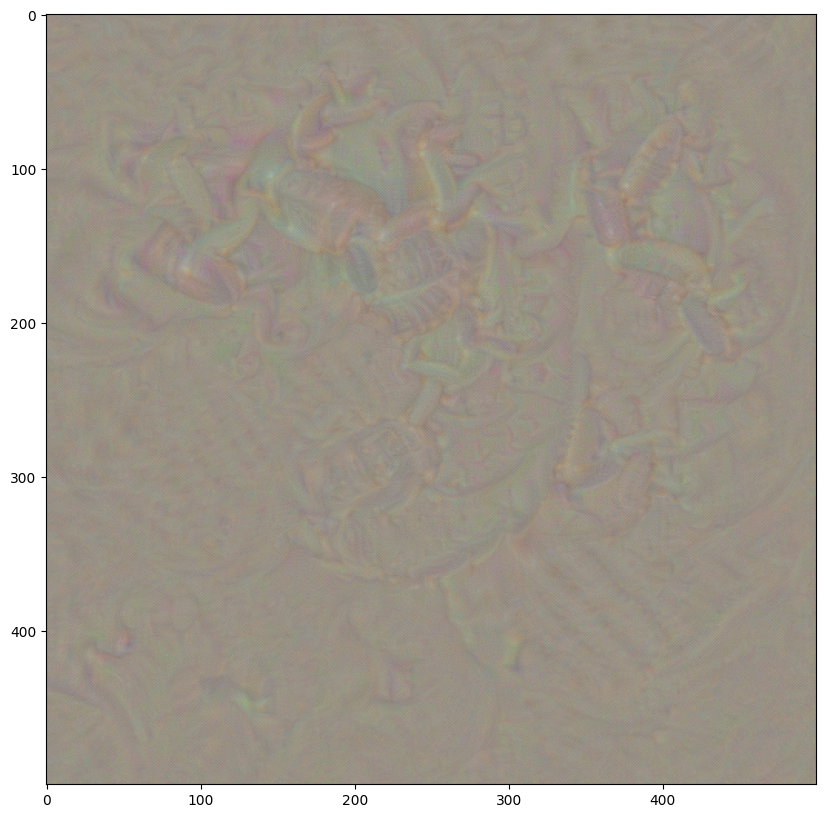

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# plt.imshow(np.squeeze(input_image).T)
plt.imshow(deprocess(np.squeeze(input_image)).T)

In [55]:
def deprocess(image):
    img = image.copy()
    img[0, :, :] *= 0.229
    img[1, :, :] *= 0.224
    img[2, :, :] *= 0.225
    img[0, :, :] += 0.485
    img[1, :, :] += 0.456
    img[2, :, :] += 0.406
    return img
    
    

In [ ]:
pyramid_image_org = PyramidImage(image)
org = pyramid_image_org.img_numpy

In [ ]:
out.data.detach().numpy() == pyramid_image.data

In [ ]:
processed = pyramid_image.img_numpy

In [ ]:
processed.shape

In [ ]:
org.shape

In [ ]:
np.array_equal(org, processed)

In [ ]:
out.shape

In [ ]:
processed = out.data.detach().numpy()
processed = np.squeeze(out.detach().numpy())
processed = processed.transpose(1, 2, 0)

In [ ]:
from torchvision import models